In [1]:
from sena.data.norec.dataloader import load_full_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [2]:
# Loading data
data = load_full_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

# Shuffling data
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

# Cleaning values in the text column
train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

# Combining data for later use
combined_data = pd.concat([train, val, test]).reset_index(drop=True)

In [3]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

# Deciding the vocabulary size
num_words = len(num_words) / 10
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 39000


In [4]:
from keras.preprocessing.text import Tokenizer

# Separating texts and labels
X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

# Fitting a tokenizer to text from the combined data
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

# Converting texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [5]:
from keras_preprocessing.sequence import pad_sequences
import numpy as np

# Deciding embedding vector length
maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

# Padding sequences with zeros until they reach a certain length
X_train = pad_sequences(X_train, maxlen=maxlen, padding="post", truncating="post")
X_val = pad_sequences(X_val, maxlen=maxlen, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=maxlen, padding="post", truncating="post")

In [6]:
from keras.utils.np_utils import to_categorical

num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

Number of classes: 3


In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 210)
y_train shape: (34903, 3)

X_val shape: (4360, 210)
y_val shape: (4360, 3)

X_test shape: (4351, 210)
y_test shape: (4351, 3)


In [8]:
import itertools

# 10 most common words in the vocabulary
dict(itertools.islice(tokenizer.word_index.items(), 10))

{'<OOV>': 1,
 'film': 2,
 'gjør': 3,
 'litt': 4,
 'får': 5,
 'komm': 6,
 'spill': 7,
 'først': 8,
 'helt': 9,
 'stor': 10}

In [9]:
from sena.utils.embeddings import load_embeddings

embeddings_index = load_embeddings()

Extracting embeddings...


Loading embeddings: 100%|██████████| 4480047/4480047 [11:45<00:00, 6346.64it/s] 


In [10]:
import numpy as np
from tqdm import tqdm

word_index = tokenizer.word_index

embedding_dim = 100
vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tqdm(word_index.items(), desc="Creating embedding matrix"):
    embedding_vector = embeddings_index.item().get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Creating embedding matrix: 100%|██████████| 388411/388411 [00:03<00:00, 119068.81it/s]


In [11]:
from keras import Input
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Sequential

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(Input(shape=(maxlen,), dtype="float32"))
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 100)          38841200  
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv1d (Conv1D)             (None, 206, 256)          128256    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 128)           163968    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                         

In [17]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor="val_accuracy", patience=3),
             EarlyStopping(monitor="val_loss", patience=3)]

epochs = 20
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=callbacks)

Epoch 1/20
546/546 [==============================] - 63s 114ms/step - loss: 0.7001 - accuracy: 0.7472 - val_loss: 0.5920 - val_accuracy: 0.7743
Epoch 2/20
546/546 [==============================] - 62s 114ms/step - loss: 0.6299 - accuracy: 0.7548 - val_loss: 0.6076 - val_accuracy: 0.7752
Epoch 3/20
546/546 [==============================] - 59s 108ms/step - loss: 0.5779 - accuracy: 0.7664 - val_loss: 0.5676 - val_accuracy: 0.7789
Epoch 4/20
546/546 [==============================] - 57s 105ms/step - loss: 0.5184 - accuracy: 0.7855 - val_loss: 0.5808 - val_accuracy: 0.7784
Epoch 5/20
546/546 [==============================] - 57s 104ms/step - loss: 0.4373 - accuracy: 0.8176 - val_loss: 0.6127 - val_accuracy: 0.7711
Epoch 6/20
546/546 [==============================] - 57s 103ms/step - loss: 0.3353 - accuracy: 0.8604 - val_loss: 0.8860 - val_accuracy: 0.7748
Epoch 1/20
118/546 [=====>........................] - ETA: 52s - loss: 0.2384 - accuracy: 0.9019

KeyboardInterrupt: 

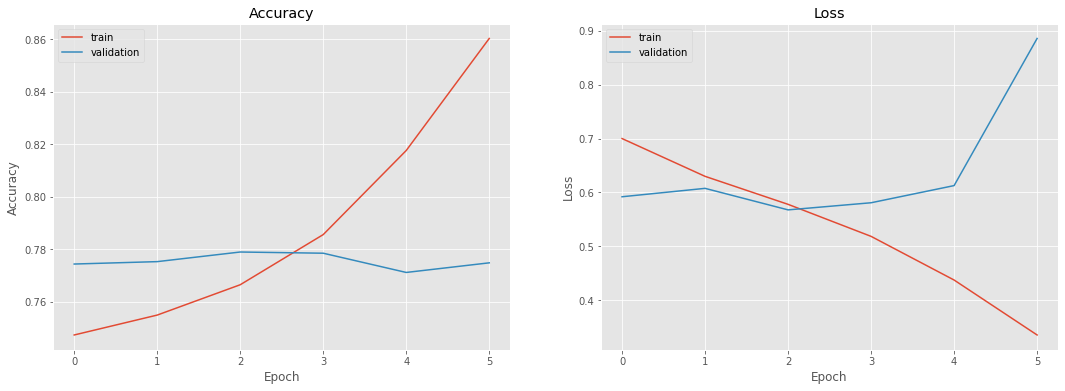

In [14]:
from sena.utils.visualization import plot_history

plot_history(history)

In [15]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

136/136 [==============================] - 4s 27ms/step - loss: 0.8665 - accuracy: 0.7801
Validation loss: 0.8664752244949341
Validation accuracy: 0.7800505757331848


In [16]:
from datetime import datetime

if val_acc > 0.8:
    print("Saving model...")
    model.save(f"models/SA-CNN-GLOVE-MULTICLASS-{val_acc}-{datetime.now().strftime('%Y%m%d')}.h5")